In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

# Utils

In [2]:
import math
from enum import Enum
from typing import Type


class Sector:

    def __init__(self, id_number: int, demands: int, workers: int, distances: list[float]) -> None:
        """This class represents a sector.
        :param id_number: Identification number.
        :param demands: Number of demands / services to be made.
        :param workers: Number of workers.
        :param distances: Distance array to other sectors this -> other.
        """
        self.id_number = id_number
        self.demands = demands
        self.workers = workers
        self.distances = distances
        self.score = self._calc_score()

    @classmethod
    def init_with_score(cls, id: int, score: int, distances: list[float]) -> 'Sector':
        sector: Sector = Sector(id, 0, 0, distances)
        sector.score = score
        return sector

    def remove_worker(self) -> None:
        """This void method is used to remove a worker from the sector, updating its score.
        """
        self.workers -= 1

    def add_worker(self) -> None:
        """This void method is used to add a worker to the sector, updating its score.
        """
        self.workers += 1

    def _calc_score(self) -> int:
        """This method is used to update the sector's score.
        """
        raw_score: int = (2 * self.workers) - self.demands
        return (-math.ceil(abs((2 * self.workers) - self.demands) / 2) if raw_score < 0
                else math.floor(((2 * self.workers) - self.demands) / 2))

    def transfer(self, receiver: any) -> int:
        """This method is used to transfer workers between sectors.
        :return: Number of workers transferred.
        """
        counter: int = 0
        while self.score > 0 > receiver.score and self.score - 1 >= 0:
            receiver.add_worker()
            receiver.score += 1
            self.remove_worker()
            self.score -= 1
            counter += 1
        return counter

    def __str__(self) -> str:
        return (f'Sector(id={self.id_number},'
                f'demands={self.demands},'
                f'workers={self.workers},'
                f'score={self.score}, '
                )


class SolutionType(Enum):
    DONE: 'SolutionType' = 0
    UNFEASIBLE: 'SolutionType' = 1
    SUBOPTIMAL: 'SolutionType' = 2


class Transaction:
    def __init__(self, sender_sector: Sector, receiver_sector: Sector) -> None:
        """This class represents a transaction of workers between sectors.
        :param sender_sector: Sector that is sending the workers.
        :param receiver_sector: Sector that is receiving the workers.
        """
        self.sender_sector: Sector = sender_sector
        self.receiver_sector: Sector = receiver_sector
        self.amount = 1

    @classmethod
    def constructor_with_amount(cls, sender_sector, receiver_sector, amount) -> 'Transaction':
        """This class method is used to construct a transaction of workers between sectors specifying the amount of
        workers moved.
        :param sender_sector: Sector that is sending the workers.
        :param receiver_sector: Sector that is receiving the workers.
        :param amount: Amount of workers moved.
        """
        transaction: Transaction = Transaction(sender_sector, receiver_sector)
        transaction.amount = amount
        return transaction

    def equals(self, other_transaction: 'Transaction') -> bool:
        """This method is used to compare transactions.
        :param other_transaction: Transaction that should be compared with self.
        :return: If transactions are equal are or not (same transfer direction).
        """
        return (self.sender_sector == other_transaction.sender_sector and
                self.receiver_sector == other_transaction.receiver_sector)

    def add(self) -> None:
        """This method is used to increase the amount of transferred workers in a transaction.
        """
        self.amount += 1

    def __str__(self):
        return f'Transaction({self.sender_sector.id_number} -> {self.receiver_sector.id_number} | {self.amount})'


Solution: Type[list[Transaction]] = list[Transaction]


# Algorithm

In [3]:
def evaluate_scores(sectors: list[Sector]) -> SolutionType:
    """This function is used to decide the best course of action when receiving a problem.
    :param sectors: List of sectors.
    :return: The type of the solution that should be returned.
    """
    receiver_sectors: list[Sector] = list(filter(lambda setor: setor.score < 0, sectors))

    if len(receiver_sectors) == 0:
        return SolutionType.DONE

    if sum(setor.score for setor in sectors) < 0:
        return SolutionType.UNFEASIBLE

    return SolutionType.SUBOPTIMAL


def algorithm(sectors: list[Sector]) -> tuple[Solution, float]:
    """This function is  used to run the whole greedy algorithm for the allocation problem.
    :param sectors: List of sectors.
    :return: Best solution in the form of a list of transactions and the cost of the solution.
    """
    receiver_sectors: list[Sector] = list(filter(lambda setor: setor.score < 0, sectors))
    sender_sectors: list[Sector] = list(filter(lambda setor: setor.score > 0, sectors))

    cost: float = 0

    if evaluate_scores(sectors) == SolutionType.SUBOPTIMAL:
        return_solution: Solution = []

        while len(receiver_sectors) > 0:
            receiver_sector: Sector = receiver_sectors[0]
            sender_sectors.sort(key=lambda sector: sector.distances[receiver_sector.id_number])
            index: int = 0
            while receiver_sector.score < 0:
                sender_sector: Sector = sender_sectors[index]
                counter: int = sender_sector.transfer(receiver_sector)
                if counter > 0:
                    transaction: Transaction = Transaction.constructor_with_amount(sender_sector,
                                                                                   receiver_sector,
                                                                                   counter
                                                                                   )
                    cost += sender_sector.distances[receiver_sector.id_number]
                    return_solution.append(transaction)
                index += 1
            receiver_sectors.remove(receiver_sector)
        return return_solution, cost
    elif len(sender_sectors) < len(receiver_sectors):
        raise ValueError('There are no feasible solutions available for this problem')
    elif sum(sector.score for sector in sender_sectors) == sum(sector.score for sector in receiver_sectors):
        raise ValueError('This is already a feasible solution.')


# Tester

## Variable 1 - Number of sectors

In [4]:
df_list: list[pd.DataFrame] = []

In [5]:
solution_list: list[pd.DataFrame] = []

In [6]:
import time
from math import floor

from matplotlib import pyplot as plt
%matplotlib inline

import random


class SectorFactory:

    @classmethod
    def generate_sector_problem(cls, n: int) -> list[Sector]:
        """ This function generates an n sector problem with a constant negative score sum = 1, thus with only 1 sector in need.
        :param n: Number of sectors in test.
        :return: Sector problem.
        """
        sectors: list[Sector] = []
        df: pd.DataFrame = pd.DataFrame(columns=["id", "score", "distances"])

        for i in range(n):
            distances: list[float] = [random.uniform(1.0, 100) for _ in range(n)]
            sectors.append(Sector(i, 0, 0, distances))

        middle: int = math.floor(len(sectors) / 2)
        givers: list[Sector] = sectors[:middle]
        takers: list[Sector] = [sec for sec in sectors if sec not in givers]

        givers[0].score += 1
        takers[0].score -= 1

        for sec in sectors:
            row = {"id": sec.id_number, "score": sec.score, "distances": sec.distances}
            df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

        df_list.append(df)

        return sectors

    @classmethod
    def generate_test(cls, tests: int) -> None:
        times: list[float] = []
        n: list[float] = []
        for i in range(tests):
            df: pd.DataFrame = pd.DataFrame(columns=["id_sender", "id_receiver", "amount_received", "solution_cost"])
            start_time: float = time.time()
            sectors: list[Sector] = SectorFactory.generate_sector_problem(i + 2)
            try:
                solution, cost = algorithm(sectors)
                for transaction in solution:
                    print(transaction)
                    row: dict = {"id_sender": transaction.sender_sector.id_number,
                                  "id_receiver": transaction.receiver_sector.id_number,
                                  "amount_received": transaction.amount
                                  }
                    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
                print()
                df.loc[0, "solution_cost"] = cost
                solution_list.append(df)

            except ValueError:
                pass
            except TypeError:
                pass
            end_time: float = time.time()
            n.append(i)
            times.append(end_time - start_time)

        plt.plot(n, times, label='runtime (s)')
        plt.plot(n, [0.001]*len(n), label='negative score sum (un * 10⁻³)')
        plt.plot(n, [0.001]*len(n), label='number of sectors in need (un * 10⁻³)')
        plt.xlabel('number of sectors (un)')
        plt.ylim(bottom=0, top=5)
        plt.title('Algorithm')
        plt.legend()
        plt.show()


Transaction(0 -> 1 | 1)

Transaction(0 -> 1 | 1)

Transaction(0 -> 2 | 1)

Transaction(0 -> 2 | 1)

Transaction(0 -> 3 | 1)

Transaction(0 -> 3 | 1)

Transaction(0 -> 4 | 1)

Transaction(0 -> 4 | 1)

Transaction(0 -> 5 | 1)

Transaction(0 -> 5 | 1)

Transaction(0 -> 6 | 1)

Transaction(0 -> 6 | 1)

Transaction(0 -> 7 | 1)

Transaction(0 -> 7 | 1)

Transaction(0 -> 8 | 1)

Transaction(0 -> 8 | 1)

Transaction(0 -> 9 | 1)

Transaction(0 -> 9 | 1)

Transaction(0 -> 10 | 1)

Transaction(0 -> 10 | 1)

Transaction(0 -> 11 | 1)

Transaction(0 -> 11 | 1)

Transaction(0 -> 12 | 1)

Transaction(0 -> 12 | 1)

Transaction(0 -> 13 | 1)

Transaction(0 -> 13 | 1)

Transaction(0 -> 14 | 1)

Transaction(0 -> 14 | 1)

Transaction(0 -> 15 | 1)

Transaction(0 -> 15 | 1)

Transaction(0 -> 16 | 1)

Transaction(0 -> 16 | 1)

Transaction(0 -> 17 | 1)

Transaction(0 -> 17 | 1)

Transaction(0 -> 18 | 1)

Transaction(0 -> 18 | 1)

Transaction(0 -> 19 | 1)

Transaction(0 -> 19 | 1)

Transaction(0 -> 20 | 1)

Tran

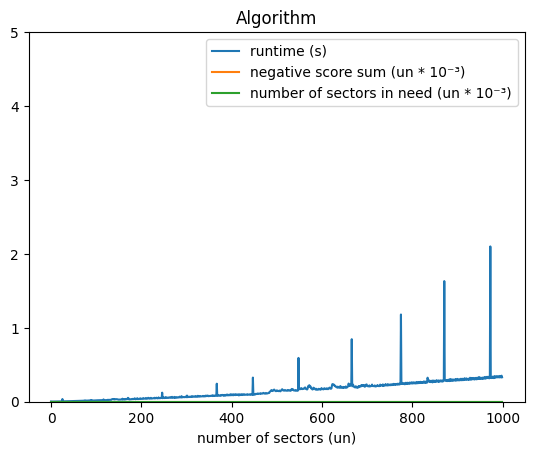

In [7]:
SectorFactory.generate_test(1000)

Download test dataframes

In [8]:
var: int = 1
test_number: int = 0
for df in df_list:
  name: str = f'var{var}-problem-{test_number}.csv'
  df.to_csv(name, index=False)
  
  test_number += 1

test_number = 0

for df in solution_list:
  name: str = f'var{var}-solution-{test_number}.csv'
  df.to_csv(name, index=False)
  
  test_number += 1

## Variable 2 - Negative Score

In [9]:
df_list: list[pd.DataFrame] = []

In [10]:
solution_list: list[pd.DataFrame] = []

In [11]:
import time
from math import floor

from matplotlib import pyplot as plt
%matplotlib inline

import random


class SectorFactory:

    @classmethod
    def generate_sector_problem(cls, n: int) -> list[Sector]:
        """ This function generates an n sector problem with a non-constant negative score sum, but with constant number of sector in need = 1.
        :param n: Number of sectors in test.
        :return: Sector problem
        """
        sectors: list[Sector] = []
        df: pd.DataFrame = pd.DataFrame(columns=["id", "score", "distances"])
        for i in range(n):
            distances: list[float] = [random.uniform(1.0, 100) for _ in range(n)]
            sectors.append(Sector(i, 0, 0, distances))

        middle: int = math.floor(len(sectors) / 2)
        givers: list[Sector] = sectors[:middle]
        takers: list[Sector] = [sec for sec in sectors if sec not in givers]

        givers[0].score += 100 * n
        takers[0].score -= 100 * n

        for sec in sectors:
            row = {"id": sec.id_number, "score": sec.score, "distances": sec.distances}
            df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

        df_list.append(df)
        return sectors

    @classmethod
    def generate_test(cls, tests: int) -> None:
        times: list[float] = []
        n: list[float] = []
        for i in range(tests):
            df: pd.DataFrame = pd.DataFrame(columns=["id_sender", "id_receiver", "amount_received", "solution_cost"])
            start_time: float = time.time()
            sectors: list[Sector] = SectorFactory.generate_sector_problem(i + 2)
            try:
                solution, cost = algorithm(sectors)
                for transaction in solution:
                    print(transaction)
                    row: dict = {"id_sender": transaction.sender_sector.id_number,
                                "id_receiver": transaction.receiver_sector.id_number,
                                "amount_received": transaction.amount
                                }
                    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
                print()
                df.loc[0, "solution_cost"] = cost
                solution_list.append(df)
            except ValueError:
                pass
            except TypeError:
                pass
            end_time: float = time.time()
            n.append(i)
            times.append(end_time - start_time)
        plt.plot(n, times, label='runtime (s)')
        plt.plot(n, [i * 0.001 for i in n], label='negative score sum (un * 10⁻⁵)')
        plt.plot(n, [0.001 for i in n], label='sectors with negative scores (un * 10⁻³)')
        plt.xlabel('number of sectors(un)')
        plt.ylim(bottom=0, top=5)
        plt.title('Algorithm')
        plt.legend()
        plt.show()


Transaction(0 -> 1 | 200)

Transaction(0 -> 1 | 300)

Transaction(0 -> 2 | 400)

Transaction(0 -> 2 | 500)

Transaction(0 -> 3 | 600)

Transaction(0 -> 3 | 700)

Transaction(0 -> 4 | 800)

Transaction(0 -> 4 | 900)

Transaction(0 -> 5 | 1000)

Transaction(0 -> 5 | 1100)

Transaction(0 -> 6 | 1200)

Transaction(0 -> 6 | 1300)

Transaction(0 -> 7 | 1400)

Transaction(0 -> 7 | 1500)

Transaction(0 -> 8 | 1600)

Transaction(0 -> 8 | 1700)

Transaction(0 -> 9 | 1800)

Transaction(0 -> 9 | 1900)

Transaction(0 -> 10 | 2000)

Transaction(0 -> 10 | 2100)

Transaction(0 -> 11 | 2200)

Transaction(0 -> 11 | 2300)

Transaction(0 -> 12 | 2400)

Transaction(0 -> 12 | 2500)

Transaction(0 -> 13 | 2600)

Transaction(0 -> 13 | 2700)

Transaction(0 -> 14 | 2800)

Transaction(0 -> 14 | 2900)

Transaction(0 -> 15 | 3000)

Transaction(0 -> 15 | 3100)

Transaction(0 -> 16 | 3200)

Transaction(0 -> 16 | 3300)

Transaction(0 -> 17 | 3400)

Transaction(0 -> 17 | 3500)

Transaction(0 -> 18 | 3600)

Transaction

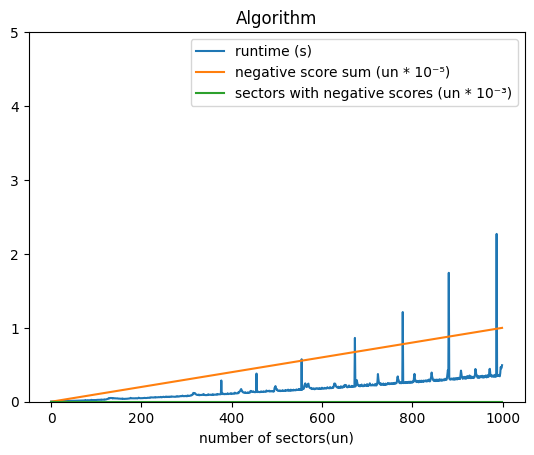

In [12]:
SectorFactory.generate_test(1000)

Downloading test dataframes

In [13]:
var: int = 2
test_number: int = 0
for df in df_list:
  name: str = f'var{var}-problem-{test_number}.csv'
  df.to_csv(name, index=False)
  
  test_number += 1

test_number = 0

for df in solution_list:
  name: str = f'var{var}-solution-{test_number}.csv'
  df.to_csv(name, index=False)
  
  test_number += 1

## Variable 3 - Number of sectors in need

In [20]:
df_list: list[pd.DataFrame] = []

In [21]:
solution_list: list[pd.DataFrame] = []

In [22]:
import time
from math import floor

from matplotlib import pyplot as plt
%matplotlib inline

import random


class SectorFactory:

    @classmethod
    def generate_sector_problem(cls, n: int) -> list[Sector]:
        """ This function generates an n sector problem with a non-constant negative score sum and a non-constant number of sectors in need.
        :param n: Number of sectors in test.
        :return: Sector problem
        """
        sectors: list[Sector] = []
        df: pd.DataFrame = pd.DataFrame(columns=["id", "score", "distances"])
        for i in range(n):
            distances: list[float] = [random.uniform(1.0, 100) for _ in range(n)]
            sectors.append(Sector(i, 0, 0, distances))

        middle: int = math.floor(len(sectors) / 2)
        givers: list[Sector] = sectors[:middle]
        takers: list[Sector] = [sec for sec in sectors if sec not in givers]

        for i in range(len(takers)):
            takers[i].score -= math.floor((100 * n)/(i + 1))
            givers[random.randint(0, len(givers) - 1)].score += math.floor((100 * n)/(i + 1))

        for sec in sectors:
            row = {"id": sec.id_number, "score": sec.score, "distances": sec.distances}
            df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

        df_list.append(df)
        return sectors

    @classmethod
    def generate_test(cls, tests: int) -> None:
        times: list[float] = []
        n: list[float] = []
        for i in range(tests):
            df: pd.DataFrame = pd.DataFrame(columns=["id_sender", "id_receiver", "amount_received", "solution_cost"])
            start_time: float = time.time()
            sectors: list[Sector] = SectorFactory.generate_sector_problem(i + 2)
            try:
                solution, cost = algorithm(sectors)
                for transaction in solution:
                    print(transaction)
                    row: dict = {"id_sender": transaction.sender_sector.id_number,
                                "id_receiver": transaction.receiver_sector.id_number,
                                "amount_received": transaction.amount
                                }
                    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
                print()
                df.loc[0, "solution_cost"] = cost
                solution_list.append(df)
            except ValueError:
                pass
            except TypeError:
                pass
            end_time: float = time.time()
            n.append(i)
            times.append(end_time - start_time)

        sectors_in_need: list[float] = [math.floor(i/2) * 0.01 for i in n]

        plt.plot(n, times, label='runtime (s)')
        plt.plot(n, [i * 0.001 for i in n], label='negative score sum (un * 10⁻⁵)')
        plt.plot(n, sectors_in_need, label='number of sectors in need (un * 10⁻²)')
        plt.xlabel('number of sectors(un)')
        plt.ylim(bottom=0, top=5)
        plt.title('Algorithm')
        plt.legend()
        plt.show()


Downloading test dataframes

In [ ]:
SectorFactory.generate_test(500)

Transaction(0 -> 1 | 200)

Transaction(0 -> 1 | 300)
Transaction(0 -> 2 | 150)

Transaction(0 -> 2 | 400)
Transaction(1 -> 3 | 200)

Transaction(1 -> 2 | 500)
Transaction(0 -> 3 | 250)
Transaction(0 -> 4 | 166)

Transaction(1 -> 3 | 600)
Transaction(1 -> 4 | 300)
Transaction(1 -> 5 | 200)

Transaction(0 -> 3 | 525)
Transaction(2 -> 3 | 175)
Transaction(1 -> 4 | 233)
Transaction(2 -> 4 | 117)
Transaction(2 -> 5 | 233)
Transaction(2 -> 6 | 175)

Transaction(0 -> 4 | 400)
Transaction(2 -> 4 | 400)
Transaction(1 -> 5 | 200)
Transaction(2 -> 5 | 200)
Transaction(2 -> 6 | 266)
Transaction(2 -> 7 | 200)

Transaction(0 -> 4 | 900)
Transaction(2 -> 5 | 450)
Transaction(3 -> 6 | 300)
Transaction(0 -> 7 | 225)
Transaction(0 -> 8 | 180)

Transaction(2 -> 5 | 1000)
Transaction(3 -> 6 | 500)
Transaction(1 -> 7 | 250)
Transaction(4 -> 7 | 83)
Transaction(4 -> 8 | 117)
Transaction(3 -> 8 | 133)
Transaction(3 -> 9 | 200)

Transaction(4 -> 5 | 916)
Transaction(3 -> 5 | 184)
Transaction(0 -> 6 | 220)
Tra

In [ ]:
var: int = 3
test_number: int = 0
for df in df_list:
  name: str = f'var{var}-problem-{test_number}.csv'
  df.to_csv(name, index=False)
  
  test_number += 1

test_number = 0

for df in solution_list:
  name: str = f'var{var}-solution-{test_number}.csv'
  df.to_csv(name, index=False)
  
  test_number += 1